In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

import os
logdir='./DDPG/'
logging_interval = 100
animate_interval = logging_interval * 5

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [6]:
from common.multiprocessing_env import SubprocVecEnv

#num_envs = 16
num_envs = 16
# env_name = "Pendulum-v0"
# env_name = 'HalfCheetah-v1'
env_name = 'MountainCarContinuous-v0'

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

[2018-06-02 22:00:31,655] Making new env: MountainCarContinuous-v0
[2018-06-02 22:00:31,661] Making new env: MountainCarContinuous-v0
[2018-06-02 22:00:31,667] Making new env: MountainCarContinuous-v0
[2018-06-02 22:00:31,674] Making new env: MountainCarContinuous-v0
[2018-06-02 22:00:31,679] Making new env: MountainCarContinuous-v0
[2018-06-02 22:00:31,686] Making new env: MountainCarContinuous-v0
[2018-06-02 22:00:31,692] Making new env: MountainCarContinuous-v0
[2018-06-02 22:00:31,698] Making new env: MountainCarContinuous-v0
[2018-06-02 22:00:31,704] Making new env: MountainCarContinuous-v0
[2018-06-02 22:00:31,710] Making new env: MountainCarContinuous-v0
[2018-06-02 22:00:31,716] Making new env: MountainCarContinuous-v0
[2018-06-02 22:00:31,722] Making new env: MountainCarContinuous-v0
[2018-06-02 22:00:31,728] Making new env: MountainCarContinuous-v0
[2018-06-02 22:00:31,733] Making new env: MountainCarContinuous-v0
[2018-06-02 22:00:31,739] Making new env: MountainCarContinuou

In [7]:
VISUALIZE = True
SEED = 0 
MAX_PATH_LENGTH = 500 
NUM_EPISODES = 12000
if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%logging_interval==0)

#Need to look through code more before setting this. 
#env._max_episode_steps = MAX_PATH_LENGTH

[2018-06-02 22:00:34,351] Clearing 2 monitor files from previous run (because force=True was provided)


In [8]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)


class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

In [9]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

In [10]:
def createStandardDeviation(vis=False):
    all_std = [test_env(vis) for x in range(100)]
    sd = np.std(all_std)
    print ("all_std: ", all_std)
    print ("The standard deviation of the model is: ", sd)
    return sd

In [11]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

In [12]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]
print (envs.action_space)

#Hyper params:
hidden_size = 256
lr          = 3e-4
num_steps   = 20

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters())

Box(1,)


In [13]:
max_frames   = 200000
frame_idx    = 0
test_rewards = []

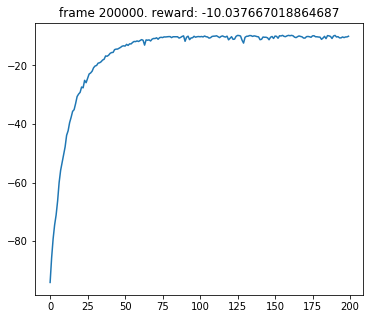

In [14]:
state = envs.reset()

while frame_idx < max_frames:

    log_probs = []
    values    = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        state = next_state
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            test_rewards.append(np.mean([test_env() for _ in range(10)]))
            plot(frame_idx, test_rewards)
            
    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values)
    
    log_probs = torch.cat(log_probs)
    returns   = torch.cat(returns).detach()
    values    = torch.cat(values)

    advantage = returns - values

    actor_loss  = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
test_env(True)

In [ ]:
createStandardDeviation(False)

In [ ]:
def plot_withStd(frame_idx, rewards):
    stdVal = createStandardDeviation(False)
    
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s standard deviation: %s' % (frame_idx, rewards[-1], stdVal))
    plt.plot(rewards)
    plt.show()

In [15]:
torch.save(model.state_dict(), './DDPG/mc_model_stateDict')

In [ ]:
werp